# Text task notebook template
## Loading the necessary libraries

In [1]:
from fastapi import APIRouter
from datetime import datetime
from datasets import load_dataset
import librosa
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

#import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

import random
import pandas as pd
import numpy as np
import sys
import json
sys.path.append('../tasks')

from utils.evaluation import AudioEvaluationRequest
from utils.emissions import tracker, clean_emissions_data, get_space_info


# Define the label mapping
LABEL_MAPPING = {
    "chainsaw": 0,
    "environment": 1
}

/Users/thomasvannier/frugal_ai_challenge/submission-template/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[codecarbon WARNING @ 10:47:16] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:47:16] [setup] RAM Tracking...
[codecarbon INFO @ 10:47:16] [setup] CPU Tracking...
[codecarbon WARNING @ 10:47:16] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 10:47:17] We saw that you have a Apple M2 Pro but we don't know it. Please contact us.
[codecarbon INFO @ 10:47:17] CPU Model on constant consumption mode: Apple M2 Pro
[codecarbon INFO @ 10:47:17] [setup] GPU Tracking...
[codecarbon INFO @ 10:47:17] No GPU found.
[codecarbon INFO

In [ ]:
from huggingface_hub import login
login()

## Loading the datasets and splitting them

In [2]:
request = AudioEvaluationRequest()

# Load and prepare the dataset
dataset = load_dataset(request.dataset_name)

# Split dataset
train_test = dataset["train"].train_test_split(test_size=request.test_size, seed=request.test_seed)
test_dataset = train_test["test"]

## Analysis

In [3]:
train = dataset["train"]
test = dataset['test']

train_df = pd.DataFrame(train)

In [ ]:
train_df.head()

In [4]:
train_df["path"] = train_df["audio"].apply(lambda x: x['path'])
train_df["array"] = train_df["audio"].apply(lambda x: x['array'])
train_df["sampling_rate"] = train_df["audio"].apply(lambda x: x['sampling_rate'])
train_df["length"] = len(train_df["array"])
train_df["time"] = len(train_df["array"])/train_df["sampling_rate"]

In [ ]:
train_df.head()

In [ ]:
train_df.shape

In [ ]:
train_df.describe()

<Axes: xlabel='label', ylabel='count'>

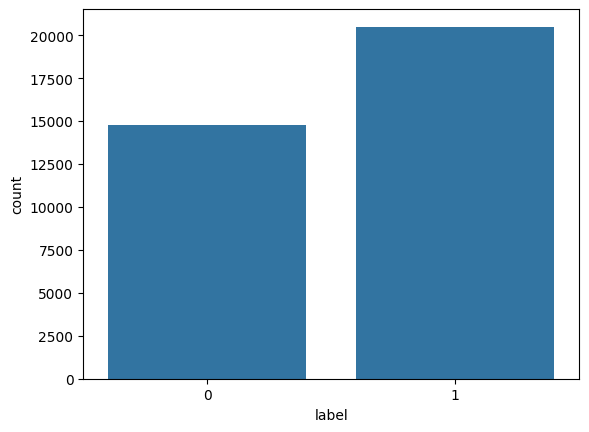

In [5]:
#train_df[["array", "sampling_rate", "label"]]
sns.countplot(train_df, x="label")

In [6]:
# Target sampling rate
target_sr = 12000

# Function to resample the audio array
def resample_audio(array, orig_sr, target_sr):
    array = np.array(array)  # Ensure it's a numpy array
    if orig_sr != target_sr:
        array = librosa.resample(array, orig_sr=orig_sr, target_sr=target_sr)
    return array

# Apply resampling to each row
train_df["resampled_array"] = train_df.apply(
    lambda row: resample_audio(row["array"], row["sampling_rate"], target_sr), axis=1
)

# Update the sampling rate column to reflect the target rate
train_df["sampling_rate"] = target_sr


In [7]:
def create_mel_spectrogram(waveform, sr, n_mels=128, n_fft=2048, hop_length=512):
    """
    Create a Mel spectrogram from a waveform.

    Args:
        waveform (np.ndarray): 1D NumPy array of the audio waveform.
        sr (int): Sampling rate of the waveform.
        n_mels (int): Number of Mel bands to generate.
        n_fft (int): Length of the FFT window.
        hop_length (int): Number of samples between successive frames.

    Returns:
        np.ndarray: 2D NumPy array of the Mel spectrogram (shape: [n_mels, time]).
    """
    # Create Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=waveform,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    
    # Convert power spectrogram (amplitude squared) to decibel (log scale)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure consistent length for each feature
    #log_mel_spec = librosa.util.fix_length(log_mel_spec, 1300)
    
    return mel_spectrogram_db

In [8]:
# Extract features for all rows
features = []
for idx, row in train_df.iterrows():
    if idx % 1000 == 0:
        print(idx)
    features.append(create_mel_spectrogram(row['resampled_array'], row['sampling_rate']))

# Convert features to a numpy array and add to the DataFrame
train_df['basic_melspect'] = features

0
1000
2000
3000
4000
5000
6000
7000
8000


/Users/thomasvannier/frugal_ai_challenge/submission-template/venv/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000


In [ ]:
train_df.head()

In [9]:
def plot_mel_spectrograms(data, labels, sr, n_samples=5):
    """
    Plots Mel spectrograms for chainsaw and rainforest sounds side-by-side.

    Args:
        data (list of np.ndarray): List of Mel spectrograms.
        labels (list of int): Corresponding labels (0 = chainsaw, 1 = rainforest).
        sr (int): Sampling rate used for the spectrograms.
        n_samples (int): Number of spectrograms to display per category.
    """
    # Filter data by label
    chainsaw_data = [data[i] for i in range(len(data)) if labels[i] == 0][:n_samples]
    rainforest_data = [data[i] for i in range(len(data)) if labels[i] == 1][:n_samples]

    # Create subplots
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 20), sharex=True, sharey=True)
    fig.suptitle("Mel Spectrograms: Chainsaw vs Rainforest", fontsize=16)

    for i in range(n_samples):
        # Plot chainsaw spectrogram in the first column
        librosa.display.specshow(
            chainsaw_data[i],
            sr=sr,
            hop_length=512,
            x_axis="time",
            y_axis="mel",
            ax=axes[i, 0],
        )
        axes[i, 0].set_title("Chainsaw Sound")
        axes[i, 0].label_outer()

        # Plot rainforest spectrogram in the second column
        librosa.display.specshow(
            rainforest_data[i],
            sr=sr,
            hop_length=512,
            x_axis="time",
            y_axis="mel",
            ax=axes[i, 1],
        )
        axes[i, 1].set_title("Rainforest Sound")
        axes[i, 1].label_outer()

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

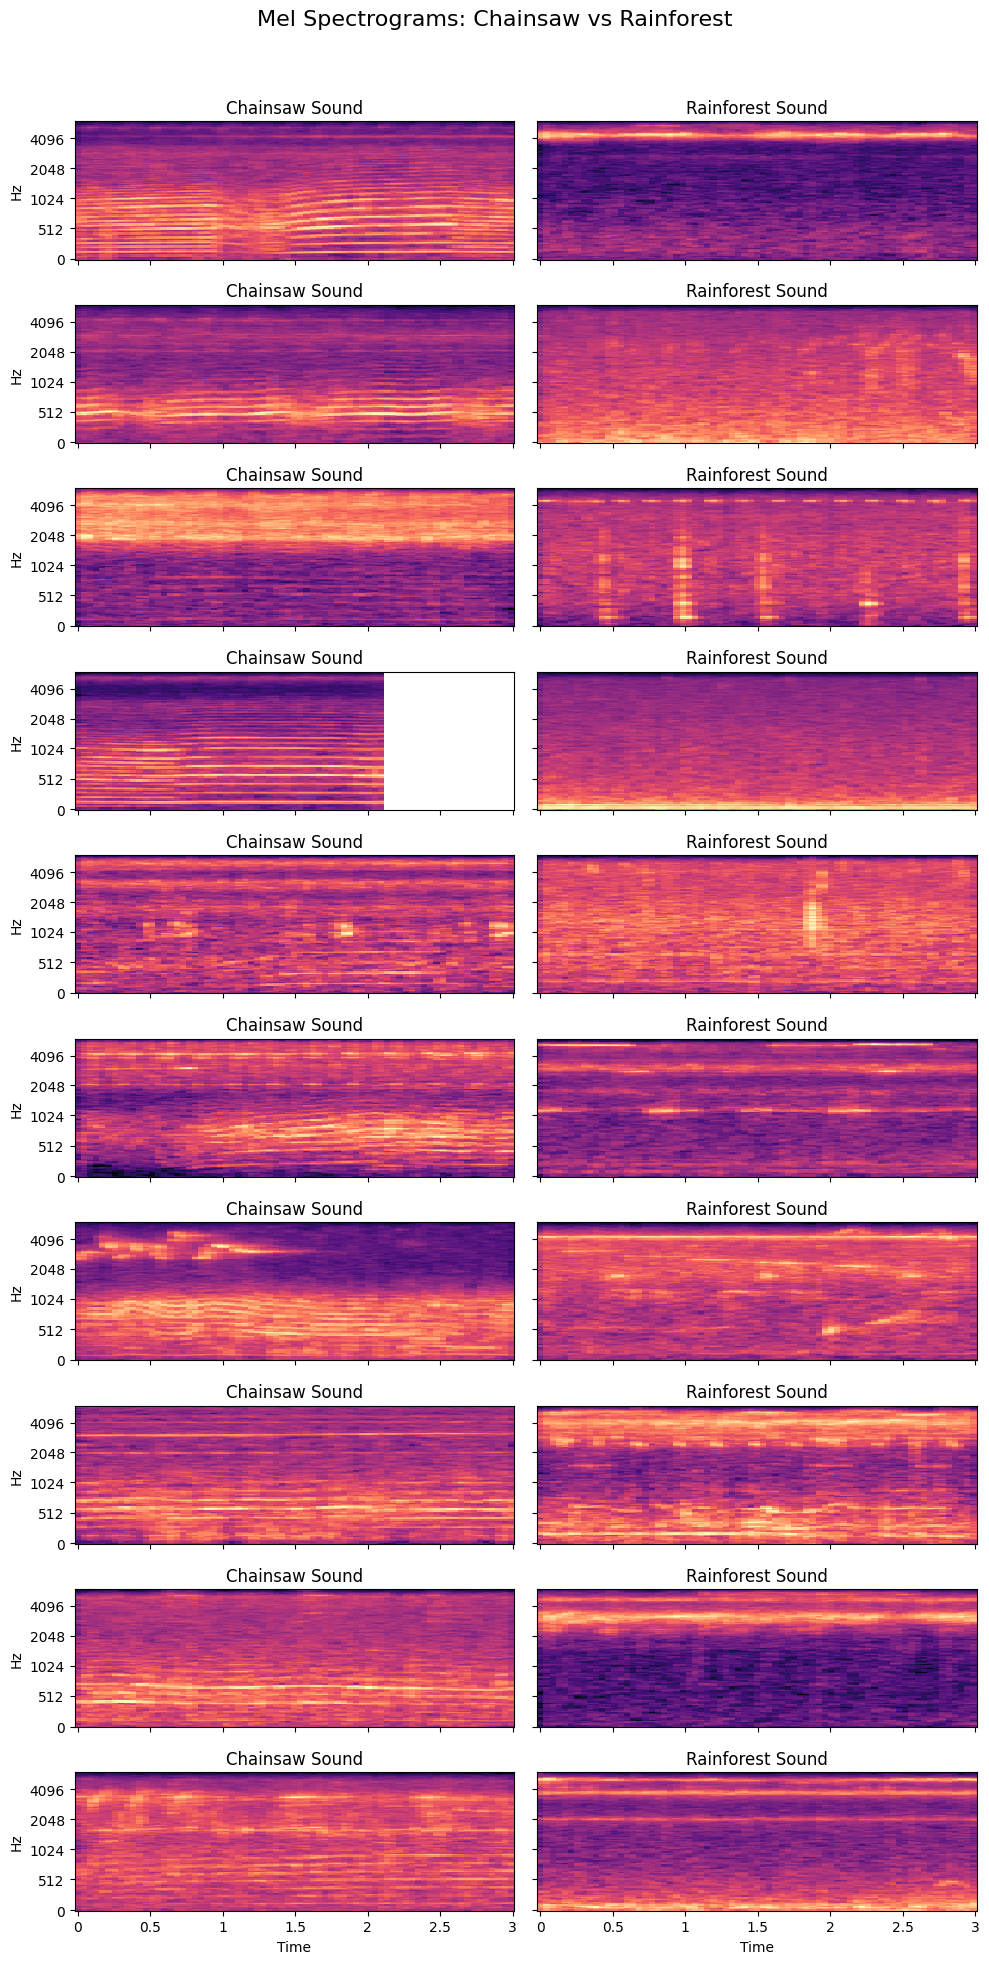

In [10]:
data = train_df['basic_melspect'].values  # Mel spectrograms
labels = train_df['label'].values  # Corresponding labels (0 or 1)
sampling_rate = 12000  # Replace with your actual sampling rate

plot_mel_spectrograms(data, labels, sr=sampling_rate, n_samples=10)

In [ ]:
# Inspect the shapes of spectrograms
shapes = train_df['basic_melspect'].apply(lambda x: x.shape).value_counts()
print("Unique shapes in dataset:", shapes)

In [11]:
train_df["shape"] = train_df['basic_melspect'].apply(lambda x: x.shape[1])
train_df = train_df[train_df["shape"]==71]

In [12]:
# Inspect the shapes of spectrograms
shapes = train_df['basic_melspect'].apply(lambda x: x.shape).value_counts()
print("Unique shapes in dataset:", shapes)

Unique shapes in dataset: basic_melspect
(128, 71)    34814
Name: count, dtype: int64


## XGBOOST

In [4]:
import sys 
print(sys.maxsize > 2**32)

True


In [13]:
import xgboost

In [14]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


# Flatten Mel Spectrograms into 1D Features
train_df["flattened_mel"] = train_df["basic_melspect"].apply(lambda x: x.flatten())

# Convert to NumPy arrays
X = np.stack(train_df["flattened_mel"].values)  # Features
y = train_df["label"].values  # Labels (0: chainsaw, 1: rainforest)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to XGBoost DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost Parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8
}

# Train XGBoost Model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Make Predictions
y_pred_probs = xgb_model.predict(dtest)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.9222
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      2937
           1       0.92      0.95      0.93      4026

    accuracy                           0.92      6963
   macro avg       0.92      0.92      0.92      6963
weighted avg       0.92      0.92      0.92      6963



In [18]:
import pickle
# Save model using pickle
with open("./../train_models/xgboost_audio_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)


## Random Baseline

In [ ]:
test_df = pd.DataFrame(test)

test_df["array"] = test_df["audio"].apply(lambda x: x['array'])
test_df["sampling_rate"] = test_df["audio"].apply(lambda x: x['sampling_rate'])

sns.countplot(test_df, x="label")


# Apply resampling to each row
test_df["resampled_array"] = test_df.apply(
    lambda row: resample_audio(row["array"], row["sampling_rate"], target_sr), axis=1
)

# Update the sampling rate column to reflect the target rate
test_df["sampling_rate"] = target_sr

# Extract features for all rows
features = []
for idx, row in test_df.iterrows():
    features.append(create_mel_spectrogram(row['resampled_array'], row['sampling_rate']))

# Convert features to a numpy array and add to the DataFrame
test_df['basic_melspect'] = features


# Inspect the shapes of spectrograms
shapes = test_df['basic_melspect'].apply(lambda x: x.shape).value_counts()
print("Unique shapes in dataset:", shapes)


test_df["shape"] = test_df['basic_melspect'].apply(lambda x: x.shape[1])
test_df = test_df[test_df["shape"]==71]



# Flatten Mel Spectrograms into 1D Features
test_df["flattened_mel"] = test_df["basic_melspect"].apply(lambda x: x.flatten())

# Convert to NumPy arrays
X = np.stack(test_df["flattened_mel"].values)  # Features
y = test_df["label"].values  # Labels (0: chainsaw, 1: rainforest)

dtest = xgb.DMatrix(X, label=y)

In [37]:
# Start tracking emissions
tracker.start()
tracker.start_task("inference")

In [ ]:

#--------------------------------------------------------------------------------------------
# YOUR MODEL INFERENCE CODE HERE
# Update the code below to replace the random baseline by your model inference within the inference pass where the energy consumption and emissions are tracked.
#--------------------------------------------------------------------------------------------   

# Make random predictions (placeholder for actual model inference)
# Make Predictions
y_pred_probs = xgb_model.predict(dtest)
predictions = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels



#--------------------------------------------------------------------------------------------
# YOUR MODEL INFERENCE STOPS HERE
#--------------------------------------------------------------------------------------------   

In [ ]:
# Stop tracking emissions
emissions_data = tracker.stop_task()
emissions_data

In [ ]:
# Calculate accuracy
# Evaluate Model
accuracy = accuracy_score(y, predictions)
print(f"Model Accuracy: {accuracy:.4f}")
#print(classification_report(y, predictions))

In [ ]:
# Prepare results dictionary
results = {
    "submission_timestamp": datetime.now().isoformat(),
    "accuracy": float(accuracy),
    "energy_consumed_wh": emissions_data.energy_consumed * 1000,
    "emissions_gco2eq": emissions_data.emissions * 1000,
    "emissions_data": clean_emissions_data(emissions_data),
    "dataset_config": {
        "dataset_name": request.dataset_name,
        "test_size": request.test_size,
        "test_seed": request.test_seed
    }
}

results